In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [17]:
env = BlackjackEnv()
#env = gym.make('Blackjack-v0')

In [18]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        # Implement this!
        # Select random action with prob epsilon
        probs = np.full(nA, epsilon/nA)
        # Find action with max q, allocate 1-epsilon probability
        a = np.argmax(Q[observation])
        probs[a] += 1- epsilon
        return probs
    return policy_fn

In [19]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_count = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # Implement this!
    # Start monitoring
    for i_episode in range(num_episodes):
        # Initialize env, and episode history recorder
        observation = env.reset()
        s_a_list = []
        reward_list = []
        # Run one episode under epsilon-greedy policy
        while True:
            action = np.random.choice(np.arange(env.action_space.n), p = policy(observation))
            s_a_list.append((observation, action))
            observation, reward, done, _ = env.step(action)
            reward_list.append(reward)
            if done:
                break
        # Count the increment in returns sum and count
        episode_length = len(reward_list)
        for i in range(episode_length):
            s, a = s_a_list[i]
            total_reward = 0
            for j in range(episode_length - i):
                total_reward += np.power(discount_factor, j) * reward_list[i + j]
            returns_count[s][a] += 1
            returns_sum[s][a] += total_reward
        # Update Q and epsilon
        for s, a in s_a_list:
            Q[s][a] = returns_sum[s][a] / returns_count[s][a]
        epsilon = epsilon * (i_episode + 1) / (i_episode + 2)
    # Get final output policy - no exploration
    policy = make_epsilon_greedy_policy(Q, epsilon = 0, nA = env.action_space.n)
    return Q, policy

In [20]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

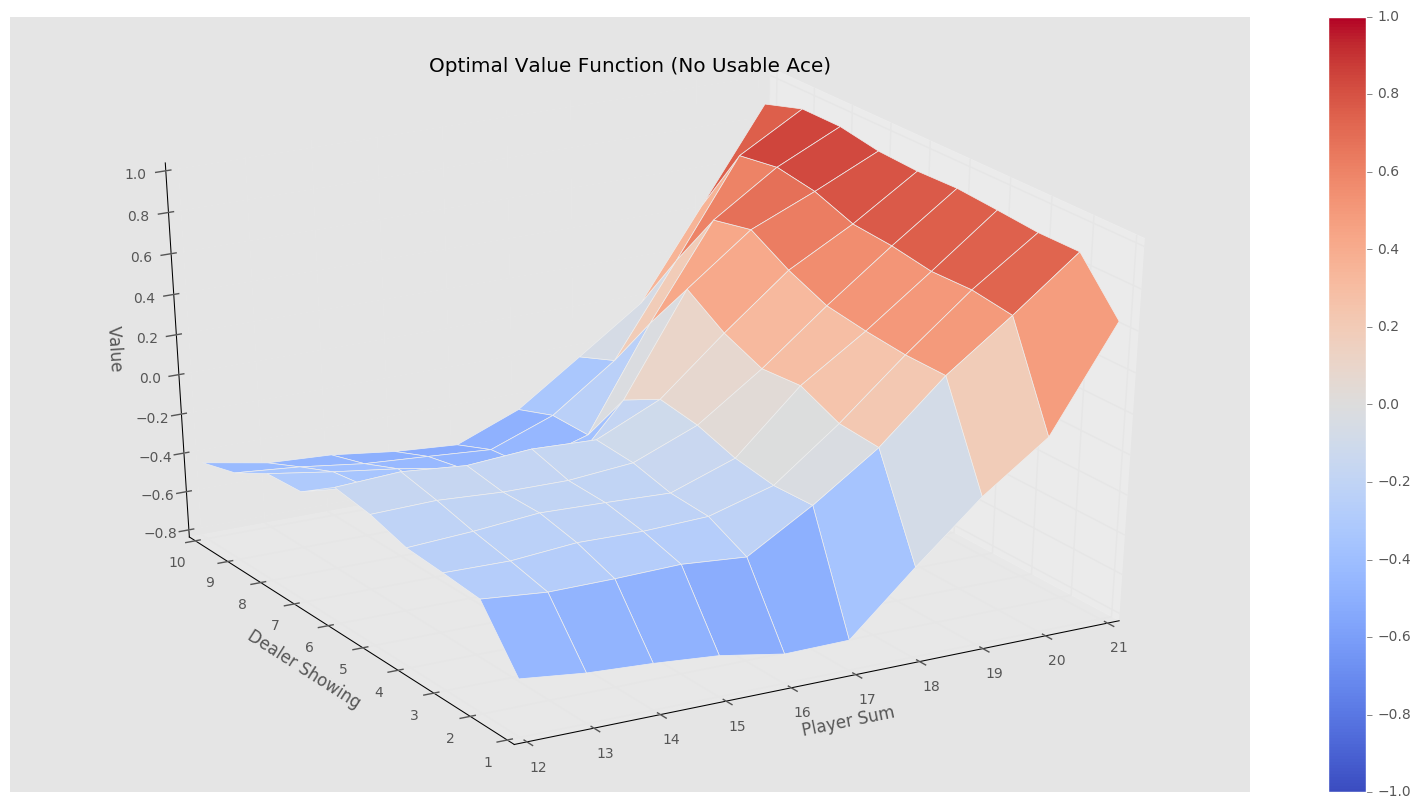

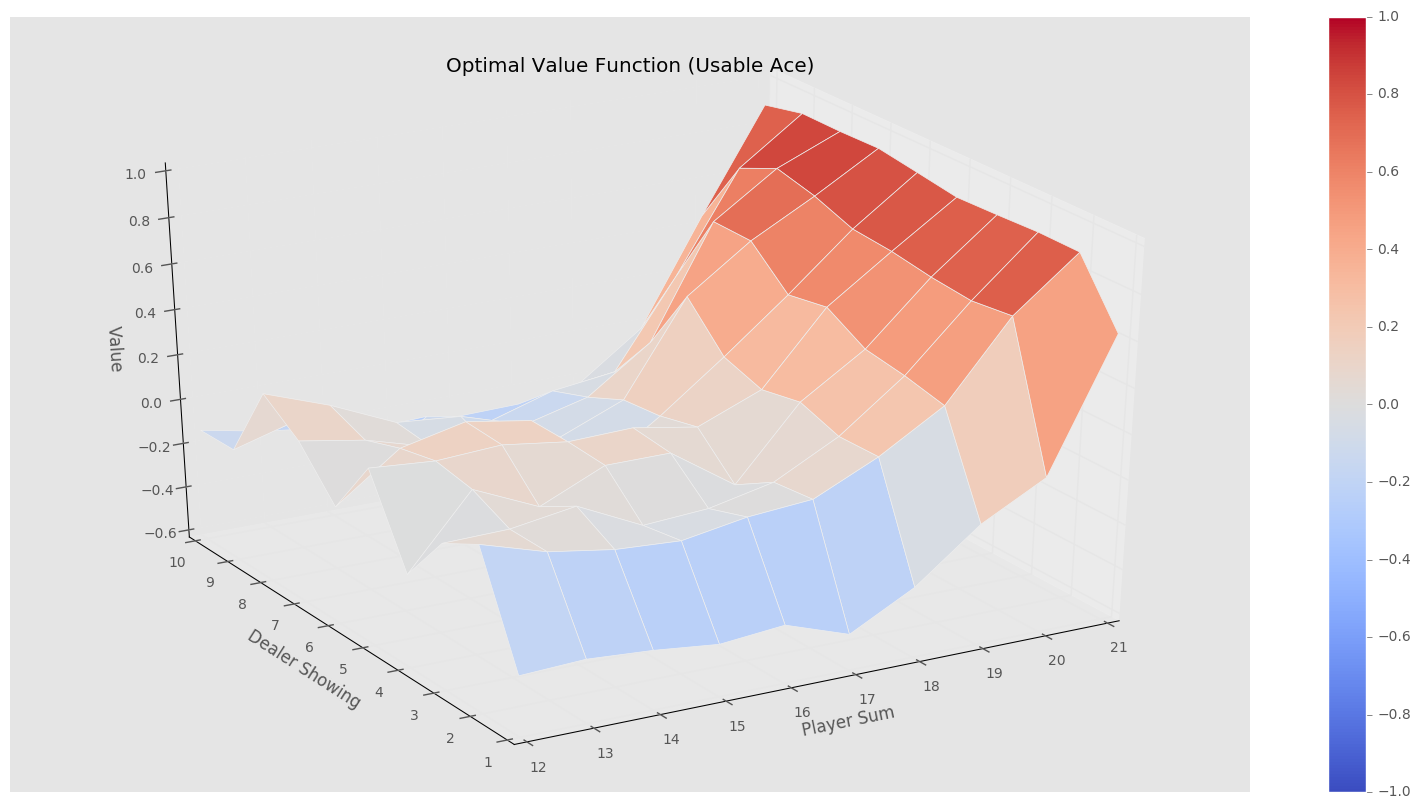

In [21]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")

__Success!__

## Discussion

Two additional questions:
* Is (this version of) Blackjack a winning game? I.e. what is the expected value?
    * -> Run simulations to answer this.
* What is the optimal strategy? Can we plot it?

And:
* Push result to OpenAI Gym

### Is Blackjac a winning game?

In [22]:
num_episodes = 1000000
v_count = 0
v_sum = 0
v_bar_so_far = []

# Sample many opennings
for i in range(num_episodes):
    observation = env.reset()
    v_count += 1
    v_sum += V[observation]
    v_bar_so_far.append(v_sum / v_count)

In [23]:
import matplotlib.pyplot as plt

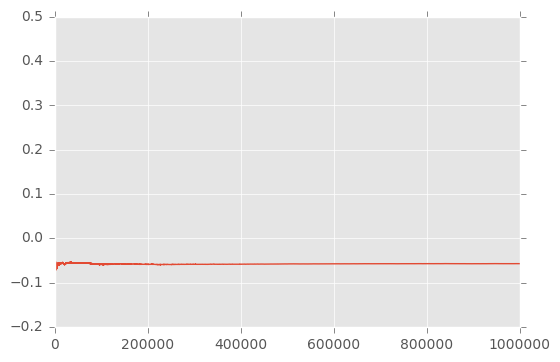

In [24]:
# Plot progression of average value function
plt.plot(v_bar_so_far)

In [25]:
print(v_bar_so_far[-1])

-0.0572194409676


Avg return quickly converged to about -0.05. In its current form Blackjack is a losing game. Even with the optimal policy the average return is still negative.

### Plot optimal policy

In [27]:
optimal_actions_no_ace = np.zeros((10, 10))
optimal_actions_yes_ace = np.zeros((10, 10))

for state, actions in Q.items():
    try:
        if not state[2]:
            best_action = np.argmax(actions)
            optimal_actions_no_ace[state[1] - 1, state[0] - 12] = best_action
        else:
            best_action = np.argmax(actions)
            optimal_actions_yes_ace[state[1] - 1, state[0] - 12] = best_action
    except:
        pass

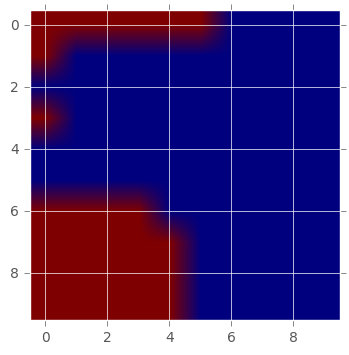

In [28]:
plt.imshow(optimal_actions_no_ace)

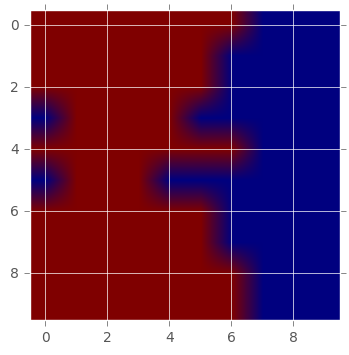

In [29]:
plt.imshow(optimal_actions_yes_ace)

You can see that little blue dot in the yes ace chart. The policy still hasn't converted to optimal..

## Publish to GYM

In [8]:
gym.upload('/tmp/blackjack-experiment-1', api_key='sk_JYEAUzXOTM6DWzeHwOA3kg')

Error: env_info {'gym_version': '0.5.2'} from training directory /tmp/blackjack-experiment-1 is missing expected key env_id. This is unexpected and likely indicates a bug in gym.